## Lab 5: Improved GAN Model

In [16]:
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, \
    BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import os

In [17]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [18]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [19]:
(X_train, y_labels), (_, _) = cifar10.load_data()
X_train.shape

(50000, 32, 32, 3)

In [20]:
# Labels in order
labels = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

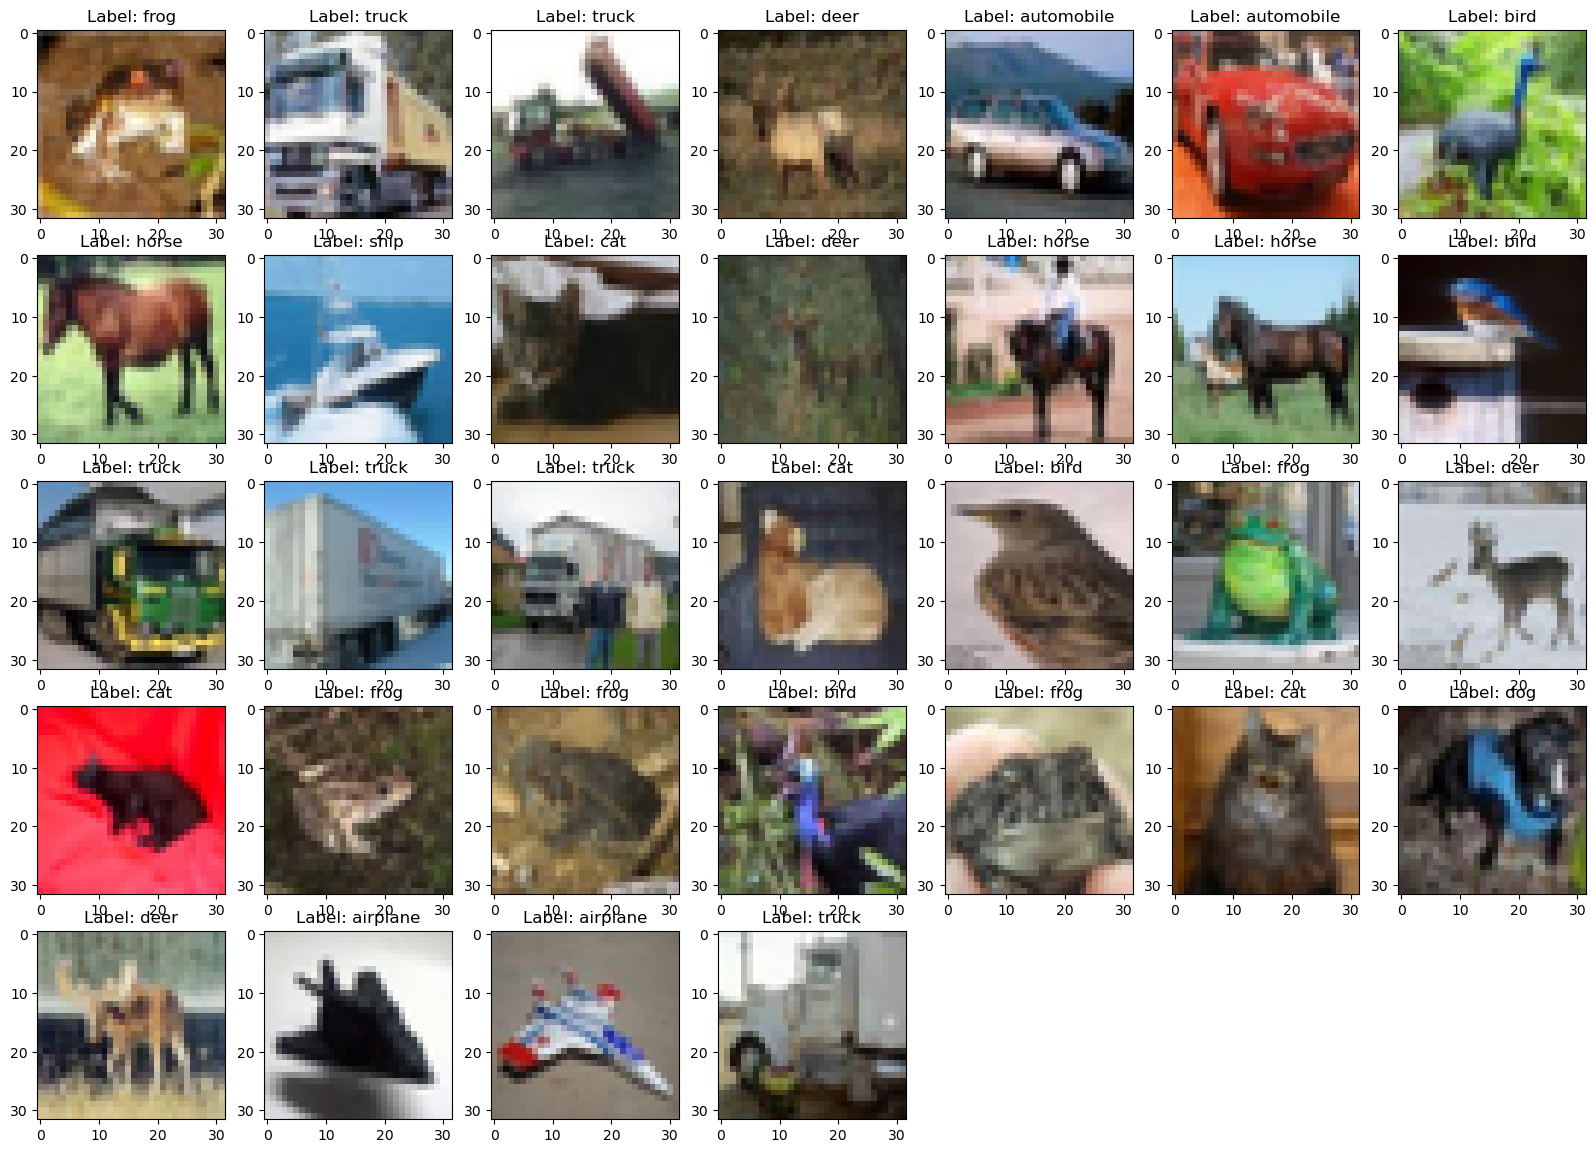

In [21]:
fig = plt.figure(0)
fig.set_size_inches(20, 20)
for i in range(0,32):
    fig.add_subplot(7, 7, i+1)
    plt.imshow(X_train[i])
    plt.title("Label: {}".format(labels[int(y_labels[i])]))

### Combine generator and discriminator into DCGAN

In [ ]:
class DCGAN():


    # # this is the function to build the generator neural network
    # def build_generator(self):
    #     model = Sequential(name='Generator')
    #     model.add(Dense(128 * 8 * 8, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
    #     model.add(Reshape((8, 8, 128)))
    #     # upsample from 8*8 to 16*16
    #     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #     model.add(LeakyReLU(alpha=0.2))
    #     # upsample to 32x32
    #     model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    #     model.add(LeakyReLU(alpha=0.2))
    #     model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
    #     model.summary()
    #     noise = Input(shape=(self.latent_dim))
    #     img = model(noise)
    #     return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    #     # define the standalone generator model
    
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(256 * 4 * 4, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 256)))
	    # upsample to 8x8
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
	    # upsample to 16x16
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
	    # upsample to 32x32
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
	    # output layer
        model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
        model.summary()
        noise = Input(shape=(self.latent_dim))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
        # define the standalone generator model
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(10, activation='softmax'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, data, z = 100):
        # Input shape
        self.X_train = data
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optim_gen = Adam(learning_rate=0.0004, beta_1=0.5)
        optim_disc = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='sparse_categorical_crossentropy',
            optimizer=optim_disc,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=self.latent_dim)
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optim_gen)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # # Load the dataset
        # (X_train, _), (_, _) = cifar10.load_data()
        # Rescale 0 to 1
        X_train = self.X_train / 255
        # X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

## Step 4: Run the model

In [ ]:
dcgan = DCGAN(rows=32, cols=32, channels=3, data=X_train)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)